## Better Way Reform Plan

In [66]:
import sys
sys.path.append("../../")
from taxcalc import *
import pandas as pd
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.transforms import BlendedGenericTransform
%matplotlib inline

### Baseline

In [67]:
policy_xx = Policy()
behavior_xx = Behavior()
records_xx = Records("../../puf.csv")

### The full reform plan

In [68]:
# Set 10% and 15% brackets to 12%
# Set 25% and 28% brackets to 25%
# Set 33%, 35% and 39.6% brackets to 33%
# Repeal Alternative minumum tax
# Standard deduction 12K for single/separate, 24K for married, 18K for single with child(Head of HH)
#    Should we eliminate the additional standard deduction for the aged and blind?
# Personal exemption '_II_credit' set to zero
# Child tax credit and non-child dependent credit implemented oddly
#    Dependent standard deduction set to $500, and child tax credit set to $1000
#    Should mimic non-refundable $500 deduction for non-child dependent and $1500 child tax credit
# Child tax credit phaseout for married couples increased to $150K
# Eliminated all itemized deductions except mortgage and charity
# Excluded half of interest income from final taxable interest income
# Cap gains & dividend income changed
#    Second cap gains threshold moved to same as fourth income tax bracket
#    Rates adjusted to 6%, 12.5% and 16.5%

# Didn't implement business pass-thru rate to 25%
# Didn't implement change from depreciation to expensing
# Didn't deal with eliminating net interest expense deductions for businesses
# Didn't eliminate Section 199
# Didn't implement changes to net operating losses
# Didn't implement tax reforms in Better Way health reforms plan




policy_y1 = Policy()
behavior_y1 = Behavior()
records_y1 = Records("../../puf.csv")
reform_y1 = {
    2017: {
        '_II_rt1': [0.12],
        '_II_rt2': [0.12],
        '_II_rt3': [0.25],
        '_II_rt4': [0.25],
        '_II_rt5': [0.33],
        '_II_rt6': [0.33],
        '_II_rt7': [0.33],
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_STD': [[12000, 24000, 12000, 18000, 24000, 12000, 500]],
        '_II_em': [0,0,0,0],
        '_CTC_c': [1500],
        '_CTC_ps': [[75000, 150000, 55000, 75000, 75000, 55000]],
        '_ID_StateLocalTax_HC': [1.0],
        '_ID_Medical_HC': [1.0],
        '_ID_Casualty_HC': [1.0],
        '_ID_Miscellaneous_HC': [1.0],
        '_ID_RealEstate_HC': [1.0],
        '_ID_BenefitSurtax_crt': [0.0],
        '_ALD_Interest_ec': [0.5],        
        '_CG_thd2': [[183250, 223050, 111525, 203150, 223050, 111525],
                     [186350, 226850, 113425, 206600, 226850, 113425],
                     [189300, 230450, 115225, 209850, 230450, 115225],
                     [190150, 231450, 115725, 210800, 231450, 115725]],
        '_CG_rt1': [0.06],
        '_CG_rt2': [0.125],
        '_CG_rt3': [0.165]
    }
}

policy_y1.implement_reform(reform_y1)

behavior_traits = {2017: {'_BE_inc': [0.0], '_BE_sub': [0.3], '_BE_cg': [0.2]}}

# Static calculators

In [69]:
calc_xx = Calculator(policy_xx, records_xx, behavior_xx)
for i in range(4):
    calc_xx.increment_year()
assert calc_xx.current_year == 2017
calc_y1 = Calculator(policy_y1, records_y1, behavior_y1)
for i in range(4):
    calc_y1.increment_year()
assert calc_y1.current_year == 2017

You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.


In [70]:
print calc_xx.current_year
print calc_y1.current_year

2017
2017


In [71]:
calc_xx.calc_all()
calc_y1.calc_all()

### Static revenue effect for 2017

In [72]:
calc_xx_combined = (calc_xx.records._combined * calc_xx.records.s006)
calc_y1_combined = (calc_y1.records._combined * calc_y1.records.s006)

diff_static_y1_xx = (calc_y1_combined - calc_xx_combined).sum() / 10**9
print "Static net revenue change: " + str(diff_static_y1_xx) + " billion dollars"

Static net revenue change: -13.7289520135 billion dollars


### Static calculator that iterates across years

In [73]:
static_path = [0] * 10

def static_path_change(calcx, calcy):
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1.calc_all()
        calc2.calc_all()
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        static_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
        
static_path_change(calc_xx, calc_y1)
print static_path

[-13.728952013456832, -8.569987985029393, -2.5340882124893986, 2.974084653262444, 8.292431999126675, 13.783269073708036, 18.76886008619012, 23.85725890712154, 28.955670941750324, 33.81785977479985]


## Behavioral calculators

In [74]:
# Behavioral factors
calc_xx.behavior.update_behavior(behavior_traits)
calc_y1.behavior.update_behavior(behavior_traits)

calc_y1_beh = Behavior.response(calc_xx, calc_y1)
print "Done"



Done


In [75]:
print calc_y1_beh.current_year

2017


### Revenue effect with behavioral changes for 2017

In [76]:
calc_y1_beh_combined = (calc_y1_beh.records._combined * calc_y1_beh.records.s006)
diff_Beh_y1_xx = (calc_y1_beh_combined - calc_xx_combined).sum() / 10**9
print "With behavioral effects, net revenue change: " + str(diff_Beh_y1_xx) + " billion dollars"

With behavioral effects, net revenue change: 14.0694976701 billion dollars


### Behavioral calculator that iterates across years

In [77]:
behavioral_path = [0] * 10

def behavioral_path_change(calcx, calcy):
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        behavioral_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
            calc1.calc_all()
            calc2.behavior.response(calc1, calc2)
        print calc2.current_year
            
        
behavioral_path_change(calc_xx, calc_y1_beh)
print behavioral_path

2018
2019
2020
2021
2022
2023
2024
2025
2026
2026
[14.069497670058613, 20.640075239203394, 28.015296104340948, 34.94781679833974, 41.853278469559484, 49.00118480058392, 55.77669742263592, 62.67506387500384, 69.66709423480557, 76.51808576114975]


## Diagnostics and analysis of reform plan

### Static diagnostics

In [78]:
numIded = calc_y1.records.s006[(calc_y1.records.c04470 > 0.) * (calc_y1.records.c00100 > 0.)].sum()
numStd = calc_y1.records.s006[(calc_y1.records._standard > 0.) * (calc_y1.records.c00100 > 0.)].sum()
print str(round(numIded / 1000) / 1000.0) + " million taxpayers using itemized deductions"
print str(round(numStd / 1000) / 1000.0) + " million taxpayers using the standard deduction"

#numIdedxx = calc_xx.records.s006[(calc_xx.records.c04470 > 0.) * (calc_xx.records.c00100 > 0.)].sum()
#numStdxx = calc_xx.records.s006[(calc_xx.records._standard > 0.) * (calc_xx.records.c00100 > 0.)].sum()
#print numIdedxx
#print numStdxx

avgmtr_xx_wage = (calc_xx.mtr('e00200p')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_wage = (calc_y1.mtr('e00200p')[2] * calc_y1.records.s006).sum() / calc_y1.records.s006.sum()
avgmtr_xx_cg = (calc_xx.mtr('p23250')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_cg = (calc_y1.mtr('p23250')[2] * calc_y1.records.s006).sum() / calc_y1.records.s006.sum()
print "\n" + "The average MTR on wage/salary income goes from " + str(avgmtr_xx_wage) + " to " + str(avgmtr_y1_wage)
print "The average MTR on long-term capital gains goes from " + str(avgmtr_xx_cg) + " to " + str(avgmtr_y1_cg)


8.308 million taxpayers using itemized deductions
150.587 million taxpayers using the standard deduction

The average MTR on wage/salary income goes from 0.246084566564 to 0.237283862384
The average MTR on long-term capital gains goes from 0.0554948996054 to 0.0730192837287


### Behavioral diagnostics

In [79]:
numIded_beh = calc_y1_beh.records.s006[(calc_y1_beh.records.c04470 > 0.) * (calc_y1_beh.records.c00100 > 0.)].sum()
numStd_beh = calc_y1_beh.records.s006[(calc_y1_beh.records._standard > 0.) * (calc_y1_beh.records.c00100 > 0.)].sum()
print str(round(numIded_beh / 1000) / 1000.0) + " million taxpayers using itemized deductions"
print str(round(numStd_beh / 1000) / 1000.0) + " million taxpayers using the standard deduction"

numIdedxx = calc_xx.records.s006[(calc_xx.records.c04470 > 0.) * (calc_xx.records.c00100 > 0.)].sum()
numStdxx = calc_xx.records.s006[(calc_xx.records._standard > 0.) * (calc_xx.records.c00100 > 0.)].sum()
print "Change in number of itemizers: " + str(round((numIded_beh - numIdedxx) / 1000) / 1000.0) + " million"


8.237 million taxpayers using itemized deductions
150.659 million taxpayers using the standard deduction
Change in number of itemizers: -37.222 million


In [80]:
avgmtr_xx_wage = (calc_xx.mtr('e00200p')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_beh_wage = (calc_y1_beh.mtr('e00200p')[2] * calc_y1_beh.records.s006).sum() / calc_y1_beh.records.s006.sum()
avgmtr_xx_cg = (calc_xx.mtr('p23250')[2] * calc_xx.records.s006).sum() / calc_xx.records.s006.sum()
avgmtr_y1_beh_cg = (calc_y1_beh.mtr('p23250')[2] * calc_y1_beh.records.s006).sum() / calc_y1_beh.records.s006.sum()
print ("The average MTR on wage/salary income goes from " + str(round(avgmtr_xx_wage * 10000) / 10000.0) +
       " to " + str(round(avgmtr_y1_wage * 10000) / 10000.0))
print ("The average MTR on long-term capital gains goes from " + str(round(avgmtr_xx_cg * 10000) / 10000.0) +
       " to " + str(round(avgmtr_y1_cg * 10000) / 10000.0))

wavgmtr_xx_wage = ((calc_xx.mtr('e00200p')[2] * calc_xx.records.c00100 * calc_xx.records.s006).sum() / 
                   (calc_xx.records.c00100 * calc_xx.records.s006).sum())
wavgmtr_y1_beh_wage = ((calc_y1_beh.mtr('e00200p')[2] * calc_y1_beh.records.c00100 * calc_y1_beh.records.s006).sum() / 
                       (calc_y1_beh.records.c00100 * calc_y1_beh.records.s006).sum())
print ("The weighted average MTR on wage income goes from " + str(round(wavgmtr_xx_wage * 10000) / 10000.0) + " to "
       + str(round(wavgmtr_y1_beh_wage * 10000) / 10000.0))

wavgmtr_xx_cg = ((calc_xx.mtr('p23250')[2] * calc_xx.records.c00100 * calc_xx.records.s006).sum() / 
                 (calc_xx.records.c00100 * calc_xx.records.s006).sum())
wavgmtr_y1_beh_cg = ((calc_y1_beh.mtr('p23250')[2] * calc_y1_beh.records.c00100 * calc_y1_beh.records.s006).sum() / 
                     (calc_y1_beh.records.c00100 * calc_y1_beh.records.s006).sum())
print ("The weighted average MTR on long-term capital gains goes from " + str(round(wavgmtr_xx_cg * 10000) / 10000.0) + " to "
       + str(round(wavgmtr_y1_beh_cg * 10000) / 10000.0))

The average MTR on wage/salary income goes from 0.2461 to 0.2373
The average MTR on long-term capital gains goes from 0.0555 to 0.073
The weighted average MTR on wage income goes from 0.3597 to 0.3418
The weighted average MTR on long-term capital gains goes from 0.1271 to 0.1281


In [81]:
num_lwrmtr = calc_y1_beh.records.s006[(calc_y1_beh.mtr('e00200p')[2] < calc_xx.mtr('e00200p'))[2]].sum()
print "Number of people with lower marginal tax rates on wages: " + str(round(num_lwrmtr / 1000) / 1000.0) + " million"

num_taxcut = calc_y1_beh.records.s006[calc_xx.records._combined > calc_y1_beh.records._combined + 0.0001].sum()
print "Number of people receiving a tax cut: " + str(round(num_taxcut / 1000) / 1000.0) + " million"

num_noinctax_y1_beh = calc_y1_beh.records.s006[calc_y1_beh.records._iitax < 0.0001].sum()
num_noinctax_xx = calc_xx.records.s006[calc_xx.records._iitax < 0.0001].sum()
print ("Change in number of people with no income tax liability: "
        + str(round((num_noinctax_y1_beh - num_noinctax_xx) / 1000) / 1000.0) + " million")

Number of people with lower marginal tax rates on wages: 69.675 million
Number of people receiving a tax cut: 78.873 million
Change in number of people with no income tax liability: 1.286 million


# Individual Reforms

In [82]:
# Must do reform plus AMT repeal and compare aginst just AMT repeal

# AMT repeal
policy_amt = Policy()
behavior_amt = Behavior()
records_amt = Records("../../puf.csv")
reform_amt = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0]
    }
}
policy_amt.implement_reform(reform_amt)

# Change in income tax rates
policy_IncTax = Policy()
behavior_IncTax = Behavior()
records_IncTax = Records("../../puf.csv")
reform_IncTax = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_II_rt1': [0.12],
        '_II_rt2': [0.12],
        '_II_rt3': [0.25],
        '_II_rt4': [0.25],
        '_II_rt5': [0.33],
        '_II_rt6': [0.33],
        '_II_rt7': [0.33]
    }
}
policy_IncTax.implement_reform(reform_IncTax)

# Deduction reforms and child tax credit
policy_ded = Policy()
behavior_ded = Behavior()
records_ded = Records("../../puf.csv")
reform_ded = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_STD': [[12000, 24000, 12000, 18000, 24000, 12000, 500]],
        '_II_em': [0,0,0,0],
        '_CTC_c': [1500],
        '_CTC_ps': [[75000, 150000, 55000, 75000, 75000, 55000]],
        '_ID_StateLocalTax_HC': [1.0],
        '_ID_Medical_HC': [1.0],
        '_ID_Casualty_HC': [1.0],
        '_ID_Miscellaneous_HC': [1.0],
        '_ID_RealEstate_HC': [1.0],
        '_ID_BenefitSurtax_crt': [0.0]
    }
}
policy_ded.implement_reform(reform_ded)

# Investment income (interest, cap gains and dividends) reforms
policy_InvTax = Policy()
behavior_InvTax = Behavior()
records_InvTax = Records("../../puf.csv")
reform_InvTax = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_CG_thd2': [[183250, 223050, 111525, 203150, 223050, 111525],
                     [186350, 226850, 113425, 206600, 226850, 113425],
                     [189300, 230450, 115225, 209850, 230450, 115225],
                     [190150, 231450, 115725, 210800, 231450, 115725]],
        '_CG_rt1': [0.06],
        '_CG_rt2': [0.125],
        '_CG_rt3': [0.165],
    }
}
policy_InvTax.implement_reform(reform_InvTax)

# Cap gains test
policy_cgtest = Policy()
behavior_cgtest = Behavior()
records_cgtest = Records("../../puf.csv")
reform_cgtest = {
    2017: {
        '_CG_rt1': [0.02],
        '_CG_rt2': [0.17],
        '_CG_rt3': [0.22],
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0]
    }
}
policy_cgtest.implement_reform(reform_cgtest)


## Static calculators

In [83]:
calc_amt = Calculator(policy_amt, records_amt, behavior_amt)
for i in range(4):
   calc_amt.increment_year()
assert calc_amt.current_year == 2017

calc_IncTax = Calculator(policy_IncTax, records_IncTax, behavior_IncTax)
for i in range(4):
    calc_IncTax.increment_year()
assert calc_IncTax.current_year == 2017

calc_ded = Calculator(policy_ded, records_ded, behavior_ded)
for i in range(4):
    calc_ded.increment_year()
assert calc_ded.current_year == 2017

calc_InvTax = Calculator(policy_InvTax, records_InvTax, behavior_InvTax)
for i in range(4):
    calc_InvTax.increment_year()
assert calc_InvTax.current_year == 2017

calc_cgtest = Calculator(policy_cgtest, records_cgtest, behavior_cgtest)
for i in range(4):
    calc_cgtest.increment_year()
assert calc_cgtest.current_year == 2017


You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.


In [84]:
print calc_amt.current_year
print calc_IncTax.current_year
print calc_ded.current_year
print calc_InvTax.current_year
print calc_cgtest.current_year

2017
2017
2017
2017
2017


In [85]:
calc_amt.calc_all()
calc_IncTax.calc_all()
calc_ded.calc_all()
calc_InvTax.calc_all()
calc_cgtest.calc_all()

In [86]:
calc_amt_combined = (calc_amt.records._combined * calc_amt.records.s006)
calc_IncTax_combined = (calc_IncTax.records._combined * calc_IncTax.records.s006)
calc_ded_combined = (calc_ded.records._combined * calc_ded.records.s006)
calc_InvTax_combined = (calc_InvTax.records._combined * calc_InvTax.records.s006)
calc_cgtest_combined = (calc_cgtest.records._combined * calc_cgtest.records.s006)

diff_static_amt_xx = (calc_amt_combined - calc_xx_combined).sum() / 10**9
diff_static_IncTax_amt = (calc_IncTax_combined - calc_amt_combined).sum() / 10**9
diff_static_ded_amt = (calc_ded_combined - calc_amt_combined).sum() / 10**9
diff_static_InvTax_amt = (calc_InvTax_combined - calc_amt_combined).sum() / 10**9
diff_static_cgtest_amt = (calc_cgtest_combined - calc_amt_combined).sum() / 10**9



### Static revenue effects of individual reforms

In [87]:
print "Static net revenue change with AMT repeal: " + str(diff_static_amt_xx) + " billion dollars"
print "Static net revenue change with income tax reform: " + str(diff_static_IncTax_amt) + " billion dollars"
print "Static net revenue change with deduction reform: " + str(diff_static_ded_amt) + " billion dollars"
print "Static net revenue change with investment tax reform: " + str(diff_static_InvTax_amt) + " billion dollars"
print "\n"
print "CG test calibration revenue change: " + str(diff_static_cgtest_amt)


Static net revenue change with AMT repeal: -41.8800806925 billion dollars
Static net revenue change with income tax reform: -119.005594196 billion dollars
Static net revenue change with deduction reform: 189.246209253 billion dollars
Static net revenue change with investment tax reform: -12.1234078992 billion dollars


CG test calibration revenue change: 13.7156255922


## Behavioral calculators

In [88]:
## Individual policy behavioral effects
calc_amt.behavior.update_behavior(behavior_traits)
calc_IncTax.behavior.update_behavior(behavior_traits)
calc_ded.behavior.update_behavior(behavior_traits)
calc_InvTax.behavior.update_behavior(behavior_traits)
calc_cgtest.behavior.update_behavior(behavior_traits)

calc_amt_beh = Behavior.response(calc_xx, calc_amt)
print "Check 1"
calc_IncTax_beh = Behavior.response(calc_amt, calc_IncTax)
print "Check 2"
calc_ded_beh = Behavior.response(calc_amt, calc_ded)
print "Check 3"
calc_InvTax_beh = Behavior.response(calc_amt, calc_InvTax)
print "Check 4"
calc_cgtest_beh = Behavior.response(calc_amt, calc_cgtest)
print "Done"


Check 1
Check 2
Check 3
Check 4
Done


### Revenue effects with behavioral changes for 2017

In [89]:
calc_amt_beh_combined = (calc_amt_beh.records._combined * calc_amt_beh.records.s006)
calc_IncTax_beh_combined = (calc_IncTax_beh.records._combined * calc_IncTax_beh.records.s006)
calc_ded_beh_combined = (calc_ded_beh.records._combined * calc_ded_beh.records.s006)
calc_InvTax_beh_combined = (calc_InvTax_beh.records._combined * calc_InvTax_beh.records.s006)
calc_cgtest_beh_combined = (calc_cgtest_beh.records._combined * calc_cgtest_beh.records.s006)

diff_Beh_amt_xx = (calc_amt_beh_combined - calc_xx_combined).sum() / 10**9
diff_Beh_IncTax_amt = (calc_IncTax_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_ded_amt = (calc_ded_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_InvTax_amt = (calc_InvTax_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_cgtest_amt = (calc_cgtest_beh_combined - calc_amt_beh_combined).sum() / 10**9

print "With behavioral effects, net revenue change from AMT repeal: " + str(diff_Beh_amt_xx) + " billion dollars"
print "With behavioral effects, net revenue change from income tax rate reform: " + str(diff_Beh_IncTax_amt) + " billion dollars"
print "With behavioral effects, net revenue change from deduction reform: " + str(diff_Beh_ded_amt) + " billion dollars"
print "With behavioral effects, net revenue change from investment tax reform: " + str(diff_Beh_InvTax_amt) + " billion dollars"
print "CG test calibration behavioral revenue change: " + str(diff_Beh_cgtest_amt)

With behavioral effects, net revenue change from AMT repeal: -41.7841600023 billion dollars
With behavioral effects, net revenue change from income tax rate reform: -86.606033122 billion dollars
With behavioral effects, net revenue change from deduction reform: 188.862321966 billion dollars
With behavioral effects, net revenue change from investment tax reform: -8.42622565114 billion dollars
CG test calibration behavioral revenue change: 12.5665011026


# MTR charts

#### Chart code taken from Brill_2016_a.ipynb

In [90]:
RES_COLUMNS = STATS_COLUMNS + ['e00200'] + ['MARS'] + ['n24']
# The results function selects the data frame we'll be using 
def results(c):
    outputs = []
    for col in RES_COLUMNS:
        if hasattr(c.policy, col):
            outputs.append(getattr(c.policy, col))
        else:
            outputs.append(getattr(c.records, col))
    return DataFrame(data=np.column_stack(outputs), columns=RES_COLUMNS)

# EPSILON is defined here to avoid division by zero 
EPSILON = 1e-3

# Calculating the weighted average MTR w.r.t wage
def wage_weighted(agg, col_name):
    return (float((agg[col_name] * agg['s006'] * agg['e00200']).sum())/
            ((agg['s006']*agg['e00200']).sum() + EPSILON))

# Calculating the weighted average MTR
def weighted(agg, col_name):
    return (float((agg[col_name] * agg['s006']).sum())/
            ((agg['s006']).sum() + EPSILON))

# The `add_income_bins` function here defines the x-axis for our plot, where desired bins will be sorted 
def add_income_bins(df, num_bins, tab):
    # First, sort by income_measure
    df.sort(tab, inplace=True)
    # Next, do a cumulative sum by the weights
    df['cumsum_weights'] = np.cumsum(df['s006'].values)
    # Max value of cum sum of weights
    max_ = df['cumsum_weights'].values[-1]
    # Create 100 bins and labels based on this cumulative weight
    bin_edges = [0] + list(np.arange(1, (num_bins+1)) * (max_ / float(num_bins)))
    labels = range(1, (num_bins+1))
    #  Groupby weighted deciles
    df['bins'] = pd.cut(df['cumsum_weights'], bins=bin_edges, labels=labels)
    return df

# The `create_mtr_graph` function allows us to obtain various plots, depending our interests. We could choose from different filing group,
# different tab (MTR to plot against), different number of kids (upper bound and lower bound) of the filer and different kind of MTR. 
# Notice that the function always requires two calculators as input. And when they are the same, only one chart will be generated. 
# MARS group, weights and tab need to be specified as well when calling the function. 
# The default setting puts no restriction on the number of kids, and uses combined MTR. 
def create_mtr_graph(calcX, calcY, MARS, weights, tab, kids_less_or_equal=1000, kids_greater_or_equal = 0, combined_or_IIT = 'combined'):
    a, mtr_iit_x, mtr_combined_x = calcX.mtr()
    a, mtr_iit_y, mtr_combined_y = calcY.mtr()
    df_x = results(calcX)
    df_y = results(calcY)
    df_x['mtr_iit'] = mtr_iit_x
    df_y['mtr_iit'] = mtr_iit_y
    df_x['mtr_combined'] = mtr_combined_x
    df_y['mtr_combined'] = mtr_combined_y
    
    
    df_y[tab] = df_x[tab]
    
    df_x = add_income_bins(df_x, 100, tab)
    df_y = add_income_bins(df_y, 100, tab)
    
    df_filtered_x = df_x[ (df_x['MARS']==MARS) & (df_x['n24'] >= kids_greater_or_equal) & (df_x['n24'] <= kids_less_or_equal) ].copy()
    df_filtered_y = df_y[ (df_y['MARS']==MARS) & (df_x['n24'] >= kids_greater_or_equal) & (df_x['n24'] <= kids_less_or_equal) ].copy()
    
    #Create a GroupBy object with 100 groups
    gp_x = df_filtered_x.groupby('bins', as_index=False)
    gp_y = df_filtered_y.groupby('bins', as_index=False)
    
    #Create a series of size 100
    if combined_or_IIT == 'combined':
        wmtr_x = gp_x.apply(weights, 'mtr_combined')
        wmtr_y = gp_y.apply(weights, 'mtr_combined')
    elif combined_or_IIT == 'IIT':
        wmtr_x = gp_x.apply(weights, 'mtr_iit')
        wmtr_y = gp_y.apply(weights, 'mtr_iit')

    #Create a DataFrame out of this with a default index
    wmtrx_df = DataFrame( data=wmtr_x, columns=['w_mtr'])
    wmtry_df = DataFrame( data=wmtr_y, columns=['w_mtr'])

    #Add the bin labels
    wmtrx_df['bins'] = np.arange(1,101)
    wmtry_df['bins'] = np.arange(1,101)

    #Join df_x and appld on the bin, carrying along 'w_mtr'
    #Left join means that 'rslt' is of size len(df_filtered_x)
    rsltx = pd.merge(df_filtered_x[['bins']], wmtrx_df, how='left')
    rslty = pd.merge(df_filtered_y[['bins']], wmtry_df, how='left')

    # Put that column in df_filtered_x, disregarding index of rslt
    df_filtered_x['w_mtr'] = rsltx['w_mtr'].values
    df_filtered_y['w_mtr'] = rslty['w_mtr'].values
    
    df_filtered_x.drop_duplicates(subset = 'bins', inplace = True)
    df_filtered_y.drop_duplicates(subset = 'bins', inplace = True)
    
    plt.plot(df_filtered_x.bins, df_filtered_x.w_mtr)
    if calcX != calcY:
        plt.plot(df_filtered_y.bins.unique(), df_filtered_y.w_mtr.unique())
        plt.legend(['Baseline', 'Reform'])

#### Combined MTR for single filers

C:\Users\cody.kallen\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


IndexError: tuple index out of range

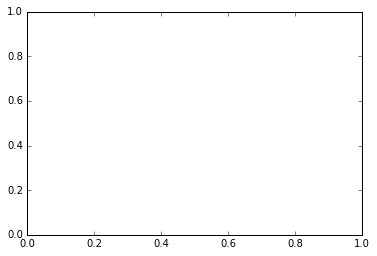

In [91]:
create_mtr_graph(calc_xx, calc_y1_beh, MARS = 1, weights = weighted, tab = 'c00100')

#### Combined MTR for joint filers

In [ ]:
create_mtr_graph(calc_xx, calc_y1_std, MARS=2,  weights = weighted, tab = 'c00100')